In [1]:
%matplotlib ipympl

from matplotlib import pyplot as plt
import numpy as np
from matplotlib import animation

import optitrack.csv_reader as csv
from optitrack.geometry import *

filename = "../material/60fps/skeleton.csv"

### READ CSV AND LOAD DATA

In [2]:
# Read the file.
take = csv.Take().readCSV(filename)

# Print out some statistics
print("Found rigid bodies:", take.rigid_bodies.keys())

# Process the first rigid body into a set of planes.
bodies = take.rigid_bodies
skeletons = take.skeletons

bones_pos = []
rigid_body_markers_pos = []
markers_pos = []

if len(bodies) > 0:
    for body in bodies: 
        bones = take.rigid_bodies[body]
        n_frames = bones.num_total_frames()
        
        bones_pos.append(bones.positions)
        for marker in bones.rigid_body_markers.values():
            rigid_body_markers_pos.append(marker.positions)
            
        for marker in bones.rigid_body_markers.values():
            markers_pos.append(marker.positions)

if len(skeletons) > 0:
    for body in skeletons: 
        skeleton = take.skeletons[body]
        n_frames = skeleton.bones["Luca:Hip"].num_total_frames()
        
        for marker in skeleton.bones.values():
            rigid_body_markers_pos.append(marker.positions)
            
        for marker in skeleton.bone_markers.values():
            markers_pos.append(marker.positions)
        

#points = bones_pos + rigid_body_markers_pos + markers_pos
points = rigid_body_markers_pos + markers_pos

#points = [[0.0,0.0,0.0] if elem is None else elem for elem in markers for markers in points ]
points = [[[0.0, 0.0, 0.0] if frame is None else frame for frame in markers] for markers in points]

np_points = np.array(points)


Found rigid bodies: dict_keys([])
[[[ 0.427239  0.853169 -0.074397]
  [ 0.428557  0.853416 -0.074021]
  [ 0.429934  0.85367  -0.073675]
  ...
  [-0.249683  0.073886 -0.222201]
  [-0.249882  0.073688 -0.222227]
  [-0.250073  0.073536 -0.222281]]

 [[ 0.422662  0.928012 -0.074213]
  [ 0.423968  0.928259 -0.073803]
  [ 0.425374  0.928514 -0.073404]
  ...
  [-0.309878  0.118556 -0.224151]
  [-0.31007   0.118369 -0.224156]
  [-0.310263  0.118216 -0.224182]]

 [[ 0.429582  1.115487 -0.058949]
  [ 0.430851  1.115686 -0.05852 ]
  [ 0.432318  1.115885 -0.058093]
  ...
  [-0.385507  0.290539 -0.227784]
  [-0.385893  0.290479 -0.227915]
  [-0.386206  0.290409 -0.227977]]

 ...

 [[ 0.501058  0.299941  0.029541]
  [ 0.501193  0.30003   0.029578]
  [ 0.501225  0.300144  0.029573]
  ...
  [ 0.112025  0.358119  0.04445 ]
  [ 0.112254  0.358412  0.044936]
  [ 0.112965  0.358795  0.045249]]

 [[ 0.59252   0.050037  0.080153]
  [ 0.592555  0.049831  0.080226]
  [ 0.592531  0.049728  0.080213]
  ...
  [ 

In [3]:
x = np_points[:,:,0]
y = np_points[:,:,1]
z = np_points[:,:,2]



### DISPLACE ANIMATION

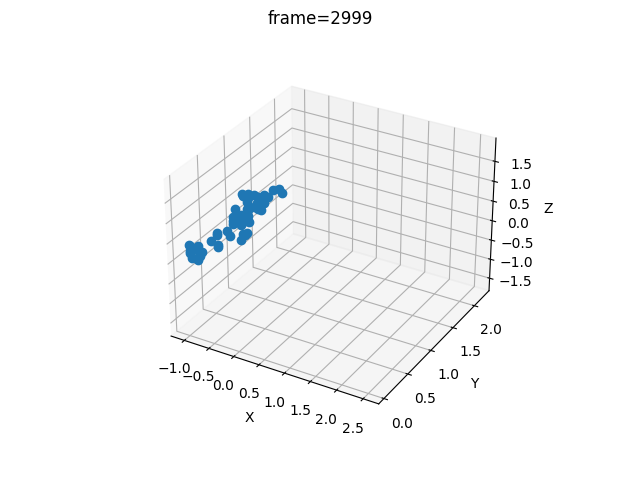

In [4]:

# Plot properties
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel('Z')

ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(y), np.max(y))
ax.set_zlim(np.min(z), np.max(z))


txt = fig.suptitle('')

# initialize empty set of points
points, = ax.plot([], [], [], "o")

# define an animation function
# this determines the plot's behavior at each frame
def update(t):
    txt.set_text('frame={:d}'.format(t))
    # print(len(x[:,t]))
    # update properties
    updated_positions = np.array((x[:,t],y[:,t],z[:,t]), dtype=float)
    
    points.set_data_3d(updated_positions)

    # return modified artists
    return points, txt

ani=animation.FuncAnimation(fig, update, frames=3000) 
ani.save(filename="animations/animation.gif", writer="pillow", fps=60)

#plt.show()